# National Tourism Promotion
## Group Project 10
### This notebook uses the EuropeTop100Attractions_ENG_20190101_20210821 and the Holidays.csv data sets

In [1]:
# Imports from the Python standard library
import os
import csv
import datetime
import re
import math
from itertools import product

# Importing from external libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import joypy
import seaborn as sns
import squarify
import pycountry
from geopy.geocoders import Nominatim
from mlxtend.frequent_patterns import apriori, association_rules
from math import ceil 

In [2]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = os.path.join(baseFolder, 'Exports')

# Check if the 'Exports' folder exists, and create it if does not
if not os.path.exists(exportsFolder):
    os.makedirs(exportsFolder)

### Define font size and colour variables in graphs created with libraries like Matplotlib or Seaborn.

In [3]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

## Data Understanding

In [4]:
# Loading Trip Advisor review data

tripadvisor_data = r'C:\Users\user\EuropeTop100Attractions_ENG_20190101_20210821.xlsx'
data = pd.ExcelFile(tripadvisor_data)
df_sheet1 = data.parse('Reviews', names=['Local ID', 'Extraction Date', 'Global Rating', 'Position on Ranking', 
                                         'Sites on Ranking', 'Total Reviews', 'User Name', 'User Location', 
                                         'User Contributions', 'Trip Type', 'Review Written', 'Review Visited', 
                                         'Review Rating', 'Review Language', 'Review Full Text'])
df_sheet2 = data.parse('Attractions', names=['Local ID', 'Attraction Name', 'Country', 'ISO'])

### Reviews Sheet Data Cleasing

In [5]:
# Summary statistics for all variables in Reviews sheet

df_sheet1 = pd.read_excel(r'C:\Users\user\EuropeTop100Attractions_ENG_20190101_20210821.xlsx', sheet_name='Reviews', decimal=",")
df_sheet1.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Local ID,92120,100,MAG001,8309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extraction Date,92120,NaN,NaN,NaN,2021-08-20 22:09:20.598932992,2021-08-20 08:24:40.077000,2021-08-20 12:08:10.831000064,2021-08-20 15:46:58.171000064,2021-08-21 12:35:39.817250048,2021-08-21 16:27:17.026000,NaN
Global Rating,92120.0,NaN,NaN,NaN,4.485166,4.0,4.5,4.5,4.5,5.0,0.178085
Position On Ranking,92120.0,NaN,NaN,NaN,3.91459,1.0,1.0,2.0,6.0,55.0,4.843013
Sites On Ranking,92120.0,NaN,NaN,NaN,748.263537,5.0,154.0,484.0,1186.0,3837.0,802.742304
Total Reviews,92120.0,NaN,NaN,NaN,40556.601813,5179.0,14152.0,24454.0,51324.0,163828.0,42914.381014
User Name,92100,65785,Malgorzata@Margo7850p,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Location,78651,12612,"London, UK",3710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Contributions,92120.0,NaN,NaN,NaN,477.52056,0.0,20.0,66.0,215.0,607732.0,7270.518677
Trip Type,63052,5,Couples,31702,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Check missing values

print(df_sheet1.isnull().sum())

Local ID                   0
Extraction Date            0
Global Rating              0
Position On Ranking        0
Sites On Ranking           0
Total Reviews              0
User Name                 20
User Location          13469
User Contributions         0
Trip Type              29068
Review Written             0
Review Visited           710
Review Rating              0
Review Language            0
Review Full Text           0
dtype: int64


1. There are missing values in "User Name" (20), "User Location" (13,468), "Trip Type" (29,068), and "Review Visited" (710) columns.
2. Local ID has 100 categories, the most important of which is MAG001 (Basilica of the Holy Family).
3. On the other hand, User Name has 65,785 categories and Malgorzata@Margo7850p has been the user who has written the most reviews.
4. Trip Type and User Location need to be treated differently in statistical analysis due to the high rate of missing values.

In [7]:
# View general information from the Reviews table

df_sheet1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92120 entries, 0 to 92119
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Local ID             92120 non-null  object        
 1   Extraction Date      92120 non-null  datetime64[ns]
 2   Global Rating        92120 non-null  float64       
 3   Position On Ranking  92120 non-null  int64         
 4   Sites On Ranking     92120 non-null  int64         
 5   Total Reviews        92120 non-null  int64         
 6   User Name            92100 non-null  object        
 7   User Location        78651 non-null  object        
 8   User Contributions   92120 non-null  int64         
 9   Trip Type            63052 non-null  object        
 10  Review Written       92120 non-null  datetime64[ns]
 11  Review Visited       91410 non-null  datetime64[ns]
 12  Review Rating        92120 non-null  int64         
 13  Review Language      92120 non-

### Correction of some place names that were incorrect.
When the spreadsheet was analysed, it was found that some data had been written incorrectly (the printouts will be included in the general report). They are now being corrected.

In [8]:
df_sheet1[False == df_sheet1['Local ID'].apply(lambda x: bool(re.match(r'^MAG\d{3}$', x)))].drop_duplicates(subset=['Local ID']).head()

,Local ID,Extraction Date,Global Rating,Position On Ranking,Sites On Ranking,Total Reviews,User Name,User Location,User Contributions,Trip Type,Review Written,Review Visited,Review Rating,Review Language,Review Full Text
18500,genis,2021-08-20 11:19:08.189,4.5,2,1234,55541,Adrian's_Quests@Adrians_Quests,"Weiden, Germany",371,NaN,2021-08-18,2021-08-01,5,en,"A very clean, well kept city center, a conglom..."
19000,u,2021-08-20 11:25:41.720,4.5,8,487,51324,Chris C@chriscX807MN,NaN,7,Family,2021-08-19,2021-08-01,4,en,Interesting visit. Lots to see. Staff very hel...


The codes below perform a conditional replacement of the values in the Local ID column based on the criteria specified in the conditions, changing the values to 'MAG005' if they are 'genis' and to 'MAG006' if they are 'u', otherwise keeping the original values.

In [9]:
df_sheet1['Local ID'] = np.where(df_sheet1['Local ID']=='genis','MAG005',df_sheet1['Local ID'])
df_sheet1['Local ID'] = np.where(df_sheet1['Local ID']=='u','MAG006',df_sheet1['Local ID'])

In [10]:
# Check some rows manually

print(df_sheet1.loc[[18500, 19000], ['Local ID', 'User Name']])

      Local ID                       User Name
18500   MAG005  Adrian's_Quests@Adrians_Quests
19000   MAG006            Chris C@chriscX807MN


### Duplicate Values Removal

If we look at the source file we can see that there are duplicate rows (Screen shots will be part of the final report). There may be cases where duplicates are considered to be different due to white space or upper and lower case letters.

In [11]:
# Identification and selection of duplicate rows in DataFrame df_sheet1 on the basis of several specific columns.

df_sheet1Duplicate = df_sheet1[df_sheet1.duplicated(subset=['Local ID', 'User Name', 'User Location',
                                                            'Trip Type', 'Review Written', 'Review Visited',
                                                            'Review Full Text'], keep=False)]
df_sheet1Duplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14024 entries, 260 to 91997
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Local ID             14024 non-null  object        
 1   Extraction Date      14024 non-null  datetime64[ns]
 2   Global Rating        14024 non-null  float64       
 3   Position On Ranking  14024 non-null  int64         
 4   Sites On Ranking     14024 non-null  int64         
 5   Total Reviews        14024 non-null  int64         
 6   User Name            14024 non-null  object        
 7   User Location        11964 non-null  object        
 8   User Contributions   14024 non-null  int64         
 9   Trip Type            9726 non-null   object        
 10  Review Written       14024 non-null  datetime64[ns]
 11  Review Visited       13920 non-null  datetime64[ns]
 12  Review Rating        14024 non-null  int64         
 13  Review Language      14024 non-nul

A Boolean mask was created to indicate which rows were duplicated based on the columns provided in the subset. The generated Boolean mask is used to filter the original data frame df_sheet1, keeping only those rows that are duplicates based on the specified columns. The output shows that the resulting data frame, named df_sheet1Duplicate, contains 14,024 entries (rows) and 15 columns.

Let's remove the duplicate lines in the method of selecting the lines to keep. In this case we keep only the rows that are not duplicates.

In [12]:
# Remove duplicate rows

df_sheet1NoDuplicate = df_sheet1[False == df_sheet1.duplicated(subset=['Local ID', 'User Name', 'User Location','Trip Type', 
                                                                       'Review Written', 'Review Visited',
                                                                       'Review Full Text'], keep = False)]
df_sheet1NoDuplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78096 entries, 0 to 92119
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Local ID             78096 non-null  object        
 1   Extraction Date      78096 non-null  datetime64[ns]
 2   Global Rating        78096 non-null  float64       
 3   Position On Ranking  78096 non-null  int64         
 4   Sites On Ranking     78096 non-null  int64         
 5   Total Reviews        78096 non-null  int64         
 6   User Name            78076 non-null  object        
 7   User Location        66687 non-null  object        
 8   User Contributions   78096 non-null  int64         
 9   Trip Type            53326 non-null  object        
 10  Review Written       78096 non-null  datetime64[ns]
 11  Review Visited       77490 non-null  datetime64[ns]
 12  Review Rating        78096 non-null  int64         
 13  Review Language      78096 non-null 

The resulting data frame, df_sheet1NoDuplicate, now has 78,096 records, indicating that duplicates have been removed based on the columns specified in the subset. The following lines referring to the data frame can be used to check this:
* RangeIndex: 92120 entries, 0 to 92119 -> Data frame without any kind of intervention.
* Int64Index: 14024 entries, 260 to 91997 -> Data frame with duplicate rows highlighted.
* Int64Index: 78096 entries, 0 to 92119 -> Data frame with duplicate rows removed.

Any remaining null values can be handled as required.

In [13]:
# Replacement of the original data frame with the new data frame without duplicates.

df_sheet1 = df_sheet1NoDuplicate

### Removal of missing values from User Name and Review Visited columns

In [14]:
# Quickly identify which columns have missing values and the size of the gaps in the data.

df_sheet1.isna().sum()

Local ID                   0
Extraction Date            0
Global Rating              0
Position On Ranking        0
Sites On Ranking           0
Total Reviews              0
User Name                 20
User Location          11409
User Contributions         0
Trip Type              24770
Review Written             0
Review Visited           606
Review Rating              0
Review Language            0
Review Full Text           0
dtype: int64

In [15]:
df_sheet1 = df_sheet1.dropna(subset=['User Name', 'Review Visited']).copy()
df_sheet1.dropna(subset=['User Name','Review Visited'], inplace=True)
df_sheet1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77490 entries, 0 to 92119
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Local ID             77490 non-null  object        
 1   Extraction Date      77490 non-null  datetime64[ns]
 2   Global Rating        77490 non-null  float64       
 3   Position On Ranking  77490 non-null  int64         
 4   Sites On Ranking     77490 non-null  int64         
 5   Total Reviews        77490 non-null  int64         
 6   User Name            77490 non-null  object        
 7   User Location        66174 non-null  object        
 8   User Contributions   77490 non-null  int64         
 9   Trip Type            53326 non-null  object        
 10  Review Written       77490 non-null  datetime64[ns]
 11  Review Visited       77490 non-null  datetime64[ns]
 12  Review Rating        77490 non-null  int64         
 13  Review Language      77490 non-null 

It can be seen that the "User Name" and "Review Visited" columns now contain the same number of total values as the other columns.

### Search for outliers with a plot

Another detail that was observed relates to the values of the User Name and User Contribution columns: there are 20 more values in User Contribution than in User Name.

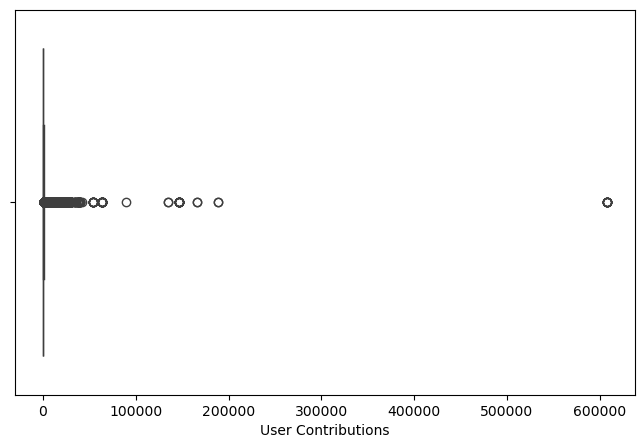

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.boxplot(data=df_sheet1, x='User Contributions')

The x-axis of the box plot shows the values present in the User Contributions column, allowing a quick view of the spread of these values and the presence of outliers.
We will identify outliers using statistical methods in Pandas, calculating the lower and upper bounds using the IQR (Interquartile Range) method to identify values outside these bounds.

In [17]:
# Calculating the IQR for 'User Contributions
Q1 = df_sheet1['User Contributions'].quantile(0.25)
Q3 = df_sheet1['User Contributions'].quantile(0.75)
IQR = Q3 - Q1

# Setting a lower and an upper limit to help identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = df_sheet1[(df_sheet1['User Contributions'] < lower_bound) | (df_sheet1['User Contributions'] > upper_bound)]

# Display of outliers
print(outliers[['User Contributions']])

       User Contributions
4                     516
11                    961
28                   1031
32                  11084
45                   3461
...                   ...
92109                1364
92110                2743
92115                2055
92116                1802
92117                1738

[9442 rows x 1 columns]


Each value in the 'User contributions' column is considered an outlier based on analysis using the IQR method. These are values that fall outside the lower and upper bounds calculated from the IQR. For example, 516 is below the lower limit, 11084 is above the upper limit, and so on. These are the values that have been identified as outliers on the basis of the outlier definition using the IQR method. The total number of rows in the Outlier DataFrame is 9442, meaning that 9442 observations in the User Contributions column were considered outliers using this approach.

We do not want to eliminate outliers. Therefore, it is better to separate them from the data set. So we created two different datasets, one containing the outliers and the other containing the remaining lines.

In [18]:
# Outlier-free line identification

no_outliers = df_sheet1[(df_sheet1['User Contributions'] >= lower_bound) & (df_sheet1['User Contributions'] <= upper_bound)]
no_outliers.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Local ID,68048,100,MAG001,7101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extraction Date,68048,NaN,NaN,NaN,2021-08-20 22:03:24.180531456,2021-08-20 08:24:40.077000,2021-08-20 11:45:56.010250240,2021-08-20 15:30:05.372000,2021-08-21 12:26:51.389750016,2021-08-21 16:27:17.026000,NaN
Global Rating,68048.0,NaN,NaN,NaN,4.482865,4.0,4.5,4.5,4.5,5.0,0.177463
Position On Ranking,68048.0,NaN,NaN,NaN,3.851899,1.0,1.0,2.0,6.0,55.0,4.747739
Sites On Ranking,68048.0,NaN,NaN,NaN,740.83591,5.0,154.0,487.0,1186.0,3837.0,777.337193
Total Reviews,68048.0,NaN,NaN,NaN,42964.035828,5179.0,14354.0,26042.0,51324.0,163828.0,45199.960865
User Name,68048,56220,NZKiwi_sunlover@NZKiwi_sunlover,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Location,56944,11463,"London, UK",2724,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Contributions,68048.0,NaN,NaN,NaN,97.243931,0.0,17.0,51.0,135.0,510.0,112.698262
Trip Type,46892,5,Couples,23421,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Outlier data set

outliers = df_sheet1[(df_sheet1['User Contributions'] < lower_bound) | (df_sheet1['User Contributions'] > upper_bound)]
outliers.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Local ID,9442,100,MAG001,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extraction Date,9442,NaN,NaN,NaN,2021-08-21 01:52:25.520406528,2021-08-20 08:24:40.159000,2021-08-20 13:49:56.232000,2021-08-21 10:11:47.988500224,2021-08-21 13:42:45.898750208,2021-08-21 16:27:11.993000,NaN
Global Rating,9442.0,NaN,NaN,NaN,4.495234,4.0,4.5,4.5,4.5,5.0,0.190408
Position On Ranking,9442.0,NaN,NaN,NaN,4.029655,1.0,1.0,2.0,5.0,55.0,5.474592
Sites On Ranking,9442.0,NaN,NaN,NaN,654.3853,5.0,119.0,382.0,861.0,3837.0,792.861981
Total Reviews,9442.0,NaN,NaN,NaN,29573.396314,5179.0,9869.0,18532.0,34703.0,163828.0,33252.909339
User Name,9442,4649,Malgorzata@Margo7850p,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Location,9230,2221,"London, UK",385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Contributions,9442.0,NaN,NaN,NaN,3226.533256,511.0,700.0,1039.0,1932.0,607732.0,20478.501419
Trip Type,6434,5,Couples,3461,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Save the resultant DataFrame to a new Excel File.

excel_file_path = os.path.join(exportsFolder, 'user_location.xlsx')
no_outliers.to_excel(excel_file_path, index=False, sheet_name='Reviews')

It is necessary to clarify that the "no_outliers" dataset is being processed for the cleaning of the user location column and therefore its name will be changed.

### Atractions Sheet Data Understanding

In [21]:
# View information from the Attractions table

df_sheet2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Local ID         100 non-null    object
 1   Attraction Name  100 non-null    object
 2   Country          100 non-null    object
 3   ISO              100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


In [22]:
df_sheet2.describe().T

,count,unique,top,freq
Local ID,100,100,MAG001,1
Attraction Name,100,99,Old Town,2
Country,100,26,Spain,17
ISO,100,25,ES,17


In [23]:
# Check for duplicates on the attractions sheet

df_sheet2.duplicated().sum()

0

No duplicate values were found in the Attractions worksheet. This can be confirmed by analysing the data in the spreadsheet itself.

* There is a country called Curaçao which is considered to belong to the Netherlands, although is situated in the Lesser Antilles, Caribbean. As this destination is likely to be competing with other islands in the Caribbean, we consider it best to remove it from the analysis as it is not part of the region being analyzed.* Another detail we noticed concerned Scotland: there is one wrong record with SCO in the country column, instead of Scotland.
* As for the Vatican City, its ISO identification in the table is VA. However, although it is considered a country, it is in Italy and can be considered a tourist attraction. That is why we're changing the ISO to IT.
* The Old Town attraction, which could be in either Warsaw, Poland or Dubrovnik, Croatia, is another error found in the spreadsheet. Using the reviews in the Review Full Text column, we were able to see which Old Town visitors were talking about and will make the necessary adjustments.


In [24]:
# Let's take a look at the lines where inconsistencies occur in the data set

df_sheet2.drop_duplicates(subset=['Country','ISO'])[['Country','ISO']].sort_values(by='Country').head(26)

,Country,ISO
6,Austria,AT
12,Belgium,BE
59,Bulgaria,BG
30,Croatia,HR
82,Curaçao,NL
75,Cyprus,CY
4,Czech Republic,CZ
2,England,UK
39,Estonia,EE
69,Finland,FI


Let's highlight the line in which the attraction that is located in Curaçao appears. And then we'll remove all the reviews for it.

In [25]:
df_sheet2[df_sheet2['Country'] == 'Curaçao']

,Local ID,Attraction Name,Country,ISO
82,MAG083,Queen Emma Pontoon Bridge,Curaçao,NL


In [26]:
df_sheet2['Local ID'] = np.where(df_sheet2['Local ID'] == 'MAG083', np.nan, df_sheet2['Local ID'])
df_sheet2.dropna(subset=['Local ID'], inplace=True)

In [27]:
# Verification that changes have been properly applied.

print(df_sheet2[df_sheet2['Local ID'] == 'MAG083'].shape[0])
print(df_sheet2[df_sheet2['Country'] == 'Curaçao'].shape[0])

0
0


In [28]:
# Correction of errors in the location of attractions.

df_sheet2['Country'] = np.where(df_sheet2['Country'] == 'Scot', 'Scotland', df_sheet2['Country'])
df_sheet2['ISO'] = np.where(df_sheet2['ISO'] == 'VA', 'IT', df_sheet2['ISO'])
df_sheet2['ISO'] = np.where((df_sheet2['ISO'] == 'HR') & (df_sheet2['Country'] == 'Poland'), 'PL', df_sheet2['ISO'])

In [29]:
# Verification that corrections are correctly applied in the Country and ISO columns

print(df_sheet2['Country'].unique())
print(df_sheet2['ISO'].unique())

['Spain' 'England' 'Czech Republic' 'Scotland' 'Austria' 'Italy'
 'Portugal' 'Greece' 'Belgium' 'Russia' 'Poland' 'France' 'Germany'
 'Croatia' 'Estonia' 'Hungary' 'Turkey' 'Bulgaria' 'Finland' 'Cyprus'
 'Latvia' 'Lithuania' 'Norway' 'Montenegro']
['ES' 'UK' 'CZ' 'AT' 'IT' 'PT' 'GR' 'BE' 'RU' 'PL' 'FR' 'DE' 'HR' 'EE'
 'HU' 'TR' 'BG' 'FI' 'CY' 'LV' 'LT' 'NO' 'ME']


In [30]:
excel_file_path = os.path.join(exportsFolder, 'Attractions_Geolocation.xlsx')
df_sheet2.to_excel(excel_file_path, index=False, sheet_name='Attractions')

## Data Preparation

We will begin data preparation with the user location column.

In [31]:
ds = pd.read_excel(r'C:\Users\user\Exports\user_location.xlsx', sheet_name='Reviews', decimal=",", engine='openpyxl')
ds.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Local ID,68048,100,MAG001,7101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extraction Date,68048,NaN,NaN,NaN,2021-08-20 22:03:24.180531456,2021-08-20 08:24:40.077000,2021-08-20 11:45:56.010250240,2021-08-20 15:30:05.372000,2021-08-21 12:26:51.389750016,2021-08-21 16:27:17.026000,NaN
Global Rating,68048.0,NaN,NaN,NaN,4.482865,4.0,4.5,4.5,4.5,5.0,0.177463
Position On Ranking,68048.0,NaN,NaN,NaN,3.851899,1.0,1.0,2.0,6.0,55.0,4.747739
Sites On Ranking,68048.0,NaN,NaN,NaN,740.83591,5.0,154.0,487.0,1186.0,3837.0,777.337193
Total Reviews,68048.0,NaN,NaN,NaN,42964.035828,5179.0,14354.0,26042.0,51324.0,163828.0,45199.960865
User Name,68048,56220,NZKiwi_sunlover@NZKiwi_sunlover,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Location,56944,11463,"London, UK",2724,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Contributions,68048.0,NaN,NaN,NaN,97.243931,0.0,17.0,51.0,135.0,510.0,112.698262
Trip Type,46892,5,Couples,23421,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's create a new DataFrame named dsLocation that contains only the 'userName' and 'userLocation' columns from the original DataFrame.

In [32]:
dsLocation = ds[['User Name','User Location']]

During analysis of the data in the Reviews spreadsheet, it was noticed that some locations in the User Location column were numbers only, when they should be representing locations. Therefore, we will identify and deal with the values that are supposed to represent places, but which have been recorded as numbers by mistake.

In [33]:
def is_number(x):
    return bool(re.match(r'^\d+$', str(x)))

# Creation of an explicit copy of the DataFrame to avoid SettingWithCopyWarning
dsCopy = dsLocation.copy()

dsCopy['User Location'] = np.where(dsCopy['User Location'].apply(is_number), np.nan, dsCopy['User Location'])

# Eliminate rows that have a null value
dsCopy.dropna(subset=['User Location'], inplace=True)
dsCopy.head(5)

,User Name,User Location
0,Maurice M@MauriceM171,"Indianapolis, IN"
1,nickchamb@nickchamb,"Bandon, Ireland"
2,Arthur Villon@arthur4588,"Valencia, Spain"
4,paul n@pauln3630,"Towaco, NJ"
6,quincy2008@quincy2008,"Barnsley, UK"


Trip Advisor does not control how users complete the location field. Therefore, the information in the User Location column is not standardised. Let's try to correct this data by splitting the User Location column into two (one for cities and one for countries). And then we will correct the column with the names of the countries only.

In [34]:
# Let's split the User Location column into a comma-separated list of values.
dsCopy['User Location'] = ds['User Location'].str.split(',')

list = dsCopy['User Location'].tolist()
print(len(list))

56919


Let's perform a fuzzy search using the pycountry library to find the ISO code of the corresponding country. If the search is successful, it returns the ISO code. Otherwise, a "Country not found" categorization is returned.

In [35]:
def do_fuzzy_search(country: str) -> str:
    try:
        result = pycountry.countries.search_fuzzy(country)
        country_obj = [c for c in result if c.alpha_2 and not c.alpha_2.startswith('-')][0]
    except Exception:
        return "Country not found"
    else:
        return country_obj.alpha_2

In [36]:
dsCopy.head(10)

,User Name,User Location
0,Maurice M@MauriceM171,"[Indianapolis, IN]"
1,nickchamb@nickchamb,"[Bandon, Ireland]"
2,Arthur Villon@arthur4588,"[Valencia, Spain]"
4,paul n@pauln3630,"[Towaco, NJ]"
6,quincy2008@quincy2008,"[Barnsley, UK]"
7,Elanita@Elanita,"[Sofiyivska Borschagivka, Ukraine]"
9,Enjoytravelz@Enjoytravelz,[France]
10,EC'sExpatLife@ECExpatLife,"[Zurich, Switzerland]"
11,Christina V@Christinavo2,"[Athens, Greece]"
12,JeroniVerdaguer@JeroniVerdaguer,[Barcelona]


Since there are still complications in the data frame, it is necessary to make some corrections. For example, Indianapolis is not IN, but US. This block creates a copy of the list as copyList. It then iterates over each element in the list and checks the length of the last element (usually the ISO code or country name after the comma). Based on the length, it decides whether it is an ISO code, a country name, or something else, and calls the do_fuzzy_search function if necessary to correct the values. The corrected values will be stored in the copyList, and the result will be printed out.

In [37]:
copyList = list.copy()

for i in range(len(list)):
    # Copying Country/ISO values
    country = list[i][-1].strip() 
    # Check if it is an ISO or not
    if len(country) > 2:
        copyList[i] = do_fuzzy_search(country)
    # If its length is 2, check to see if it is an ISO code or not.
    elif len(country) == 2:
        country = country.upper()
        if country == 'UK': # GB is not wrong, but since the rest of the data set is called UK, we will keep UK.
            copyList[i] = country
        else:    
            copyList[i] = 'US' # If we have another value, we will keep that value, e.g.: New York, NY - we will drop NY and keep New York to pass to Geopy for the next step.
    elif len(country) == 1:
        copyList[i] = np.nan
    print(copyList[i])

US
IE
ES
US
UK
UA
FR
CH
GR
ES
NL
PL
US
US
CA
NL
US
UK
US
US
UK
DE
GR
IT
US
UK
CR
ES
UK
NO
UK
IE
ES
ZA
ES
UK
US
UK
US
HR
US
US
FR
GB
EE
ES
GR
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
MX
US
US
IN
ES
ES
ES
UK
ES
UK
UK
SubdivisionHierarchy(code='US-TX', country_code='US', name='Texas', parent_code=None, type='State')
US
FR
US
US
UK
AU
IT
UK
CA
UK
UK
UK
IT
ES
NL
NL
UK
ES
UK
CA
NL
UK
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
LU
EG
UK
ES
US
UK
AU
SI
UK
TH
BE
CN
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
LU
ES
UK
ID
PL
ES
US
US
US
US
US
AU
US
UK
CA
US
AU
US
US

In [38]:
print(len(copyList) == len(list))

True


In [39]:
dsCopy['User ISO'] = copyList
dsCopy.head()

,User Name,User Location,User ISO
0,Maurice M@MauriceM171,"[Indianapolis, IN]",US
1,nickchamb@nickchamb,"[Bandon, Ireland]",IE
2,Arthur Villon@arthur4588,"[Valencia, Spain]",ES
4,paul n@pauln3630,"[Towaco, NJ]",US
6,quincy2008@quincy2008,"[Barnsley, UK]",UK


In [40]:
dsCopy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56919 entries, 0 to 68047
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User Name      56919 non-null  object
 1   User Location  56919 non-null  object
 2   User ISO       56912 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [41]:
# Additional ISO coding correction

dsCopy['User ISO'] = np.where(dsCopy['User ISO'] == 'GB', 'UK', dsCopy['User ISO'])

When state, region, or subdivision names are passed as input, the do_fuzzy_search function returns results that include subdivision codes. We have tried to modify the do_fuzzy_search function so that it only handles country names and ignores the subdivision codes, but it didn't work properly. Therefore, we are going to export the data to an Excel file and make the corrections directly in it.

In [42]:
excel_file_path = os.path.join(exportsFolder, 'dados_corrigidos.xlsx')
dsCopy.to_excel(excel_file_path, index=False, sheet_name='Reviews')

#### Data Analysis in the Excel Environment

1. The data were corrected in the Excel file "dados_corrigidos". Locations that could not be properly identified were classified as "Country not found".
2. After the correction, the file was renamed to "dados_corrigidos_manual". This was done to avoid overwriting the data when the notebook was run again.

Before starting the merging process, it is necessary to make some adjustments to the data frame that will serve as the basis for the entire operation - "no_outliers". Since we chose to remove the Curaçao location from the Attractions sheet because it was in the Caribbean and not in Europe, we need to remove it from the Reviews sheet in the same way. This will prevent discrepancies when merging data from both sheets.

In [46]:
# Check for 'MAG083' (Curaçao) in no_outliers dataframe.
if 'MAG083' in no_outliers['Local ID'].values:
    # Remova todas as linhas com 'Curaçao' no dataframe no_outliers
    no_outliers = no_outliers[no_outliers['Local ID'] != 'MAG083']

# Verification that changes have been properly applied.
print(no_outliers[no_outliers['Local ID'] == 'MAG083'].shape[0])

0


### Merge Data Sets

This code block imports two data sets: one containing the ISO codes of users' origin countries, and the other containing data about tourist attractions.


In [49]:
dsiso = pd.read_excel(r'C:\Users\user\Exports\dados_corrigidos_manual.xlsx')

In [50]:
# Now let's merge the user ratings (no_outliers) dataframe with the one we just created, which contains the ISO codes for the locations of the users.
dsmesclado = no_outliers.merge(dsiso[['User Name','User ISO']], on='User Name', how ='left')

# We need to drop duplicates because merge creates a new row every time we have a match on the User Name column.
dsmesclado.drop_duplicates(inplace=True)
dsmesclado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67737 entries, 0 to 97416
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Local ID             67737 non-null  object        
 1   Extraction Date      67737 non-null  datetime64[ns]
 2   Global Rating        67737 non-null  float64       
 3   Position On Ranking  67737 non-null  int64         
 4   Sites On Ranking     67737 non-null  int64         
 5   Total Reviews        67737 non-null  int64         
 6   User Name            67737 non-null  object        
 7   User Location        56689 non-null  object        
 8   User Contributions   67737 non-null  int64         
 9   Trip Type            46685 non-null  object        
 10  Review Written       67737 non-null  datetime64[ns]
 11  Review Visited       67737 non-null  datetime64[ns]
 12  Review Rating        67737 non-null  int64         
 13  Review Language      67737 non-null 

Before merging the information contained in the "df_sheet2" dataframe that refers to tourist attractions, we need to rename the "Local ID" column to avoid conflicts with the "dsmesclado" dataframe.


In [51]:
df_sheet2.rename(columns={'Local ID': 'Attraction ID'}, inplace=True)

In [52]:
# Now we merge the tourist attraction ISO code information with the "dsmesclado" dataframe.

merged_df = dsmesclado.merge(df_sheet2[['Attraction ID', 'ISO']], left_on='Local ID', right_on='Attraction ID', how='left')
merged_df = merged_df.drop_duplicates() 
merged_df.drop(['Attraction ID'], axis=1, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67737 entries, 0 to 67736
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Local ID             67737 non-null  object        
 1   Extraction Date      67737 non-null  datetime64[ns]
 2   Global Rating        67737 non-null  float64       
 3   Position On Ranking  67737 non-null  int64         
 4   Sites On Ranking     67737 non-null  int64         
 5   Total Reviews        67737 non-null  int64         
 6   User Name            67737 non-null  object        
 7   User Location        56689 non-null  object        
 8   User Contributions   67737 non-null  int64         
 9   Trip Type            46685 non-null  object        
 10  Review Written       67737 non-null  datetime64[ns]
 11  Review Visited       67737 non-null  datetime64[ns]
 12  Review Rating        67737 non-null  int64         
 13  Review Language      67737 non-

In [58]:
excel_file_path = os.path.join(exportsFolder, 'MergedData.xlsx')
merged_df.to_excel(excel_file_path, index=False, sheet_name='Reviews')

### Loading Holidays dataset
Let's load the information about the Holidays file to complete this first part.

In [54]:
world_holiday = pd.read_csv('Holidays.csv', sep=";")
world_holiday.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Codigo,69557.0,NaN,NaN,NaN,34778.0,20079.520674,0.0,17389.0,34778.0,52167.0,69556.0
countryOrRegion,69557,38,Sweden,8394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holidayName,69557,483,Søndag,6386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
normalizeHolidayName,69557,438,Søndag,6386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isPaidTimeOff,3934,2,True,2695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countryRegionCode,64559,34,SE,8394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,69557,20665,01/01/2001,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Display rows between January 1st, 2019 and August 21st, 2021

# Changing the data type of the 'date' column to datetime64
world_holiday['date'] = pd.to_datetime(world_holiday['date'], format='%d/%m/%Y')

# Period of time between 2019/01/01 and 2021/08/21
world_holiday_content = world_holiday[(world_holiday['date'] >= np.datetime64('2019-01-01')) & (world_holiday['date'] <= np.datetime64('2021-08-21'))]

In [56]:
# Display top five rows

world_holiday_content.head(5)

,Codigo,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
25392,25392,Argentina,Año Nuevo [New Year's Day],Año Nuevo [New Year's Day],NaN,AR,2019-01-01
25393,25393,Australia,New Year's Day,New Year's Day,NaN,AU,2019-01-01
25394,25394,Austria,Neujahr,Neujahr,NaN,AT,2019-01-01
25395,25395,Belarus,Новый год,Новый год,NaN,BY,2019-01-01
25396,25396,Belgium,Nieuwjaarsdag,Nieuwjaarsdag,NaN,BE,2019-01-01


In [57]:
# Display last five rows
world_holiday_content.tail(5)

,Codigo,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
26854,26854,Spain,Asunción de la Virgen,Asunción de la Virgen,NaN,ES,2021-08-15
26855,26855,Sweden,Söndag,Söndag,NaN,SE,2021-08-15
26856,26856,Colombia,La Asunción [Assumption of Mary](Observed),La Asunción [Assumption of Mary],NaN,CO,2021-08-16
26857,26857,Argentina,Día Pase a la Inmortalidad del General D. José...,Día Pase a la Inmortalidad del General D. José...,NaN,AR,2021-08-17
26858,26858,Hungary,Az államalapítás ünnepe,Az államalapítás ünnepe,NaN,HU,2021-08-20


In the code lines above, we have restricted the Holidays table's rows to the period we are analysing, which refers to the period between 01/01/2019 and 08/21/2021.

In [59]:
print(datetime.datetime.now())

2023-12-26 13:34:34.098932
